# Preprocessing, Modeling, and Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

----
## Preprocessing

#### Load in data and convert to matrix representation

In [3]:
posts= pd.read_csv("../data/men_women_posts_cleaned.csv")
posts.head()

,subreddit,title
0,1,What is lying about feelings to get consent? I...
1,1,How can you be physically attracted to a man w...
2,1,Who else is thinking about leaving the US?
3,1,How to respond to “I’m not into you”
4,1,"Ladies, how do you get over a man you can’t have?"


In [61]:
X= posts["title"]
y= posts["subreddit"]

X_train, X_test, y_train, y_test= train_test_split(X,y, random_state= 13, stratify= y)

In [5]:
y_train.value_counts(normalize= True)

1    0.505076
0    0.494924
Name: subreddit, dtype: float64

#### We will create a stop words list, preprocessor, and lemmatize

In [6]:
# This is the list created in our eda notebook 
stops= stopwords.words("english")

add_stop= ["women", "woman", "men", "man", "would", "ladies", "girl", "guys", 
           "feel", "like", "make", "want", "get", "know"]

combined_stop= stops + add_stop

In [7]:
# Using format from 5.05 nlp eda lesson where we created a preprocessor
def my_preprocessor(text):
    text = text.lower()
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = ' '.join(text)
    return text

In [8]:
posts['title'][13]

'For those of you who work in some form of customer service (restaurants, retail, etc.), what is your worst customer experience?'

In [9]:
my_preprocessor(posts['title'][13])

'for those of you who work in some form of customer service restaurants retail etc what is your worst customer experience'

In [10]:
# Made lematizer based on 5.05 nlp eda lesson

def my_lemmatizer(text):
    wnl= WordNetLemmatizer()
    return [wnl.lemmatize(word) for word in text.split()]

In [11]:
# need to apply same preprocessing to our stop words
wnl= WordNetLemmatizer()
lem_stop = [wnl.lemmatize(i) for i in combined_stop]

------
## Modeling

#### 1. Logistic Regression

In [12]:
pipe1= Pipeline([
    ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
    ("logreg", LogisticRegression(random_state= 13))
])

pipe1.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                ('logreg', LogisticRegression(random_state=13))])

In [13]:
pipe1.score(X_train, y_train)

0.8428591294673898

In [14]:
pipe1.score(X_test, y_test)

0.6153525239883187

Our data is pretty overfit so let's try gridseaching

In [15]:
pipe1_params= {
    "cv__max_features": [4000, 6000, 6500, 7000],
    "logreg__C": [.25, .50, .75, 1]
}

In [16]:
gs1= GridSearchCV(pipe1, param_grid= pipe1_params, cv= 5, n_jobs= -1)

In [17]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                                       ('logreg',
                                        LogisticRegression(random_state=13))]),
             n_jobs=-1,
             param_grid={'cv__max_features': [4000, 6000, 6500, 7000],
                         'logreg__C': [0.25, 0.5, 0.75, 1]})

In [18]:
gs1.score(X_train, y_train)

0.8411903768599639

In [19]:
gs1.score(X_test, y_test)

0.6170212765957447

In [20]:
gs1.best_params_

{'cv__max_features': 6000, 'logreg__C': 1}

Ater gridsearching with logistic regression, our train and test scores are pretty close. The best test score from logisitic regression is: 0.6170212765957447 with the best parameters of: ('cv__max_features': 6000, 'logreg__C': 1)

#### 2. Naive Bayes

In [21]:
pipe2= Pipeline([
    ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
    ("nb", MultinomialNB())
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                ('nb', MultinomialNB())])

In [22]:
print(f'Train Score: {pipe2.score(X_train, y_train)}\nTest Score: {pipe2.score(X_test, y_test)}')

Train Score: 0.8119872062300098
Test Score: 0.6090947017104714


In [23]:
pipe2_params= {
    "cv__max_features": [4000, 6000, 6500, 7000],
    "nb__alpha": [1, 2, 3, 4]
}

In [24]:
gs2= GridSearchCV(pipe2, param_grid= pipe2_params, cv= 5, n_jobs= -1)

In [25]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_features': [4000, 6000, 6500, 7000],
                         'nb__alpha': [1, 2, 3, 4]})

In [26]:
print(f'Train Score: {gs2.score(X_train, y_train)}\nTest Score: {gs2.score(X_test, y_test)}')

Train Score: 0.8104575163398693
Test Score: 0.609511889862328


In [27]:
gs2.best_params_

{'cv__max_features': 6000, 'nb__alpha': 1}

The testing score is still not great and lower than our logistic regression model, so we will try another one. 

#### 3. Random Forest Classifier

In [28]:
pipe3= Pipeline([
    ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
    ("rf", RandomForestClassifier(random_state= 13))
])

pipe3.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                ('rf', RandomForestClassifier(random_state=13))])

In [29]:
print(f'Train Score: {pipe3.score(X_train, y_train)}\nTest Score: {pipe3.score(X_test, y_test)}')

Train Score: 0.9923515505492977
Test Score: 0.6003337505214852


In [30]:
pipe3_params= {
    "cv__max_features": [4000, 6000, 6500],
    "rf__n_estimators": [100, 500],
    "rf__max_depth": [None, 30, 100]
}

In [31]:
gs3= GridSearchCV(pipe3, param_grid= pipe3_params, cv= 5, n_jobs= -1)

In [32]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                                       ('rf',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'cv__max_features': [4000, 6000, 6500],
                         'rf__max_depth': [None, 30, 100],
                         'rf__n_estimators': [100, 500]})

In [33]:
print(f'Train Score: {gs3.score(X_train, y_train)}\nTest Score: {gs3.score(X_test, y_test)}')

Train Score: 0.900431094423585
Test Score: 0.609511889862328


In [34]:
gs3.best_params_

{'cv__max_features': 6000, 'rf__max_depth': 100, 'rf__n_estimators': 500}

Still not doing better than logistic regression.

#### 4. AdaBoost Classifier

In [35]:
pipe4= Pipeline([
    ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
    ("ada", AdaBoostClassifier(estimator= LogisticRegression(random_state= 13), random_state= 13))
])

pipe4.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                ('ada',
                 AdaBoostClassifier(estimator=LogisticRegression(random_state=13),
                                    random_state=13))])

In [36]:
print(f'Train Score: {pipe4.score(X_train, y_train)}\nTest Score: {pipe4.score(X_test, y_test)}')

Train Score: 0.6693088582950911
Test Score: 0.6141009595327492


In [37]:
pipe4_params= {
    "cv__max_features": [4000, 6000, 6500],
    'ada__n_estimators': [100, 150],
    'ada__estimator__C': [.5, 1],
    'ada__learning_rate': [0.9, 1.01]
}

In [38]:
gs4= GridSearchCV(pipe4, param_grid= pipe4_params, cv= 5, n_jobs= -1)
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                                       ('ada',
                                        AdaBoostClassifier(estimator=LogisticRegression(random_state=13),
                                                           random_state=13))]),
             n_jobs=-1,
             param_grid={'ada__estimator__C': [0.5, 1],
                         'ada__learning_rate': [0.9, 1.01],
                         'ada__n_estimators': [100, 150],
                         'cv__max_features': [4000, 6000, 6500]})

In [39]:
print(f'Train Score: {gs4.score(X_train, y_train)}\nTest Score: {gs4.score(X_test, y_test)}')

Train Score: 0.6821026282853567
Test Score: 0.6141009595327492


In [40]:
gs4.best_params_

{'ada__estimator__C': 1,
 'ada__learning_rate': 1.01,
 'ada__n_estimators': 150,
 'cv__max_features': 6000}

Very close to our logistic regression model

#### 5. Bagging Classifier

In [41]:
pipe5= Pipeline([
    ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
    ("bag", BaggingClassifier(estimator= LogisticRegression(random_state= 13),random_state= 13))
])

pipe5.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                ('bag',
                 BaggingClassifier(estimator=LogisticRegression(random_state=13),
                                   random_state=13))])

In [42]:
print(f'Train Score: {pipe5.score(X_train, y_train)}\nTest Score: {pipe5.score(X_test, y_test)}')

Train Score: 0.818523153942428
Test Score: 0.6157697121401752


In [43]:
pipe5_params= {
    "cv__max_features": [4000, 6000, 6500],
    'bag__n_estimators': [10, 100, 150],
    'bag__estimator__C': [.5, 1]
}

In [44]:
gs5= GridSearchCV(pipe5, param_grid= pipe5_params, cv= 5, n_jobs= -1)
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(preprocessor=<function my_preprocessor at 0x7fd5542f3ca0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function my_lemmatizer at 0x7fd55433b700>)),
                                       ('bag',
                                        BaggingClassifier(estimator=LogisticRegression(random_state=13),
                                                          random_state=13))]),
             n_jobs=-1,
             param_grid={'bag__estimator__C': [0.5, 1],
                         'bag__n_estimators': [10, 100, 150],
                         'cv__max_features': [4000, 6000, 6500]})

In [45]:
print(f'Train Score: {gs5.score(X_train, y_train)}\nTest Score: {gs5.score(X_test, y_test)}')

Train Score: 0.8268669169795578
Test Score: 0.6153525239883187


In [46]:
gs5.best_params_

{'bag__estimator__C': 1, 'bag__n_estimators': 100, 'cv__max_features': 6000}

Bagging was also very close to our logistic regression model score.

#### Finally, let's try stacking models to improve our test score 

In [47]:
level1_estimators = [
    ('logreg_pipe', Pipeline([
        ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
        ('logreg', LogisticRegression(random_state= 13))
    ])),
    
    ('nb_pipe', Pipeline([
        ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
        ('nb', MultinomialNB())
    ])),
    ('bag_pipe', Pipeline([
        ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
        ('bag', BaggingClassifier(random_state= 13))
    ])),
    
    ('ada_pipe', Pipeline([
        ("cv", CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)),
        ('ada', AdaBoostClassifier(random_state= 13))
    ])),

]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression(random_state= 13))

stacked_model.fit(X_train, y_train)

print(f'Train Score: {stacked_model.score(X_train, y_train)}\nTest Score: {stacked_model.score(X_test, y_test)}')

Train Score: 0.915867056042275
Test Score: 0.6220275344180225


This is the best test score we have had. Logistic regression shows to be the best estimator for our data, so it was used as the final estimator in the stacked model. The stacked model uses logistic regression, naive bayes, bagging and ada boosting as it's level 1 estimators because we saw many of those models alone had decent testing scores. However, this model is only correctly classifying the posts 62.2 % of the time with the testing data. This means the model has many misclassifications.

-------
## Evaluation

#### Let's evaluate this stacked model now.

In [48]:
preds= stacked_model.predict(X_test)

In [49]:
stacked_model.score(X_test, y_test)

0.6220275344180225

In [50]:
# Baseline 
y_test.value_counts(normalize= True)

1    0.505215
0    0.494785
Name: subreddit, dtype: float64

We can see the baseline accuracy above is 50.5% by classifying every post to the AskWomen subreddit. Our stacked model is higher than this baseline as it has a 62.2% accuracy for classifying posts.

Let's see the misclassification rate:

In [51]:
print(1 - stacked_model.score(X_train, y_train))
print(1 - stacked_model.score(X_test, y_test))

0.08413294395772497
0.3779724655819775


The model is clearly overfit to the training data and is misclassifying the testing 37.8% of the time

#### Let's find the specificity and recall 

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [53]:
# Specificity

print(f'Specificity: {tn/(tn + fp)}')

Specificity: 0.5961214165261383


In [54]:
# Recall

print(f'Recall: {tp/(tp + fn)}')

Recall: 0.6473988439306358


Specificity is higher, so our model is getting more false positives (classifying as AskWomen when it is AskMen) than false negatives. 

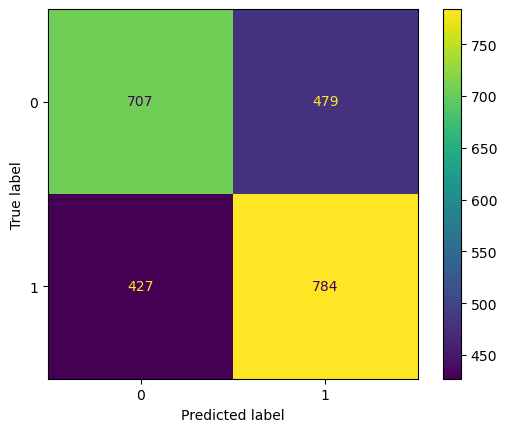

In [55]:
ConfusionMatrixDisplay.from_estimator(stacked_model, X_test, y_test);

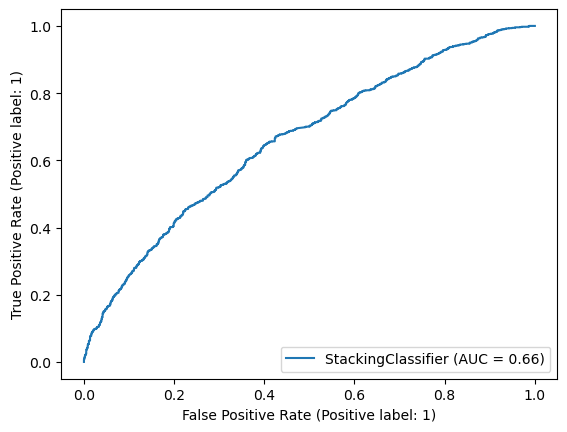

In [56]:
RocCurveDisplay.from_estimator(stacked_model, X_test, y_test);

Ideally, we want the ROC curve to have an "elbow" in the top left corner, but it sticks very close to the middle of the graph. Also, we want an AUC close to 1, but here it is very close to 0.5,  so we can see it is not the best model at classifying a post into the subreddits.

#### I want to look at the testing data's posts that were misclassified to asses for myself

In [68]:
test_df= pd.DataFrame(X_test, columns= ["title"])
test_df["subreddit"]= y_test
test_df["subreddit_pred"]= preds
test_df.head()

,title,subreddit,subreddit_pred
2639,"Older women, usually 30+ have less men interes...",1,0
3134,Tips on how to wean a 14 month old from breast...,1,0
907,How do you get through work with period pain?,1,1
4477,How do woman keep online dating?,1,0
8960,What made you start paying attention to gender...,0,1


In [69]:
misclassified= test_df[test_df["subreddit"] != test_df["subreddit_pred"]]

In [70]:
misclassified.head()

,title,subreddit,subreddit_pred
2639,"Older women, usually 30+ have less men interes...",1,0
3134,Tips on how to wean a 14 month old from breast...,1,0
4477,How do woman keep online dating?,1,0
8960,What made you start paying attention to gender...,0,1
8676,Men who had been on an abusive/toxic relations...,0,1


In [80]:
misclass_men= misclassified[misclassified["subreddit"]==0]
misclass_women=  misclassified[misclassified["subreddit"]==1]

In [81]:
# looking at the top words in each type of misclassified posts

cv= CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None)

women_cv= cv.fit_transform(misclass_women["title"])
women_cv_df= pd.DataFrame(women_cv.todense(), columns= cv.get_feature_names_out())

men_cv= cv.fit_transform(misclass_men["title"])
men_cv_df= pd.DataFrame(men_cv.todense(), columns= cv.get_feature_names_out())

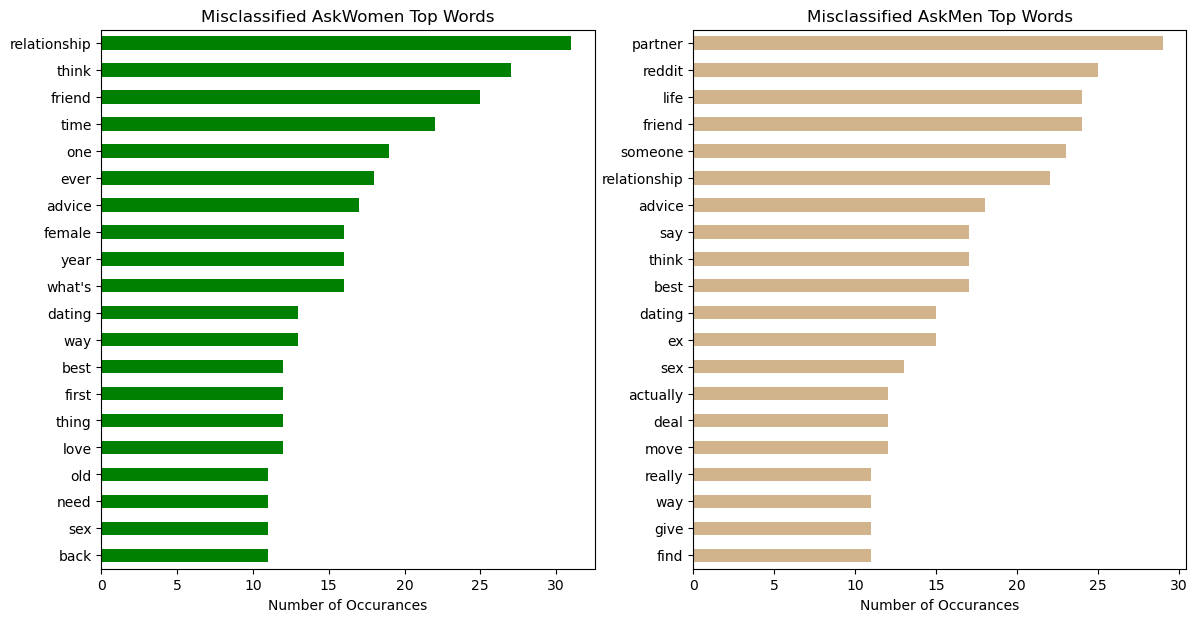

In [96]:
fig, ax = plt.subplots(1, 2, figsize= (14,7))

women_cv_df.sum().sort_values(ascending= False).head(20).plot(kind= "barh", ax=ax[0], color= "green")

men_cv_df.sum().sort_values(ascending= False).head(20).plot(kind= "barh", ax=ax[1], color= "tan")

ax[0].set(xlabel='Number of Occurances', title= "Misclassified AskWomen Top Words")
ax[1].set(xlabel='Number of Occurances', title= "Misclassified AskMen Top Words")

ax[0].invert_yaxis()
ax[1].invert_yaxis();

There is a decent amount of overlap for words used in AskMen and AskWomen. It seems like a large number of people are discussing aspects of their relationships in both subreddits, thus making it harder to distinguish between the two. 

In [87]:
cv_bi= CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None, ngram_range=(2,2))

women_bi= cv_bi.fit_transform(misclass_women["title"])
women_bi_df= pd.DataFrame(women_bi.todense(), columns= cv_bi.get_feature_names_out())

men_bi= cv_bi.fit_transform(misclass_men["title"])
men_bi_df= pd.DataFrame(men_bi.todense(), columns= cv_bi.get_feature_names_out())

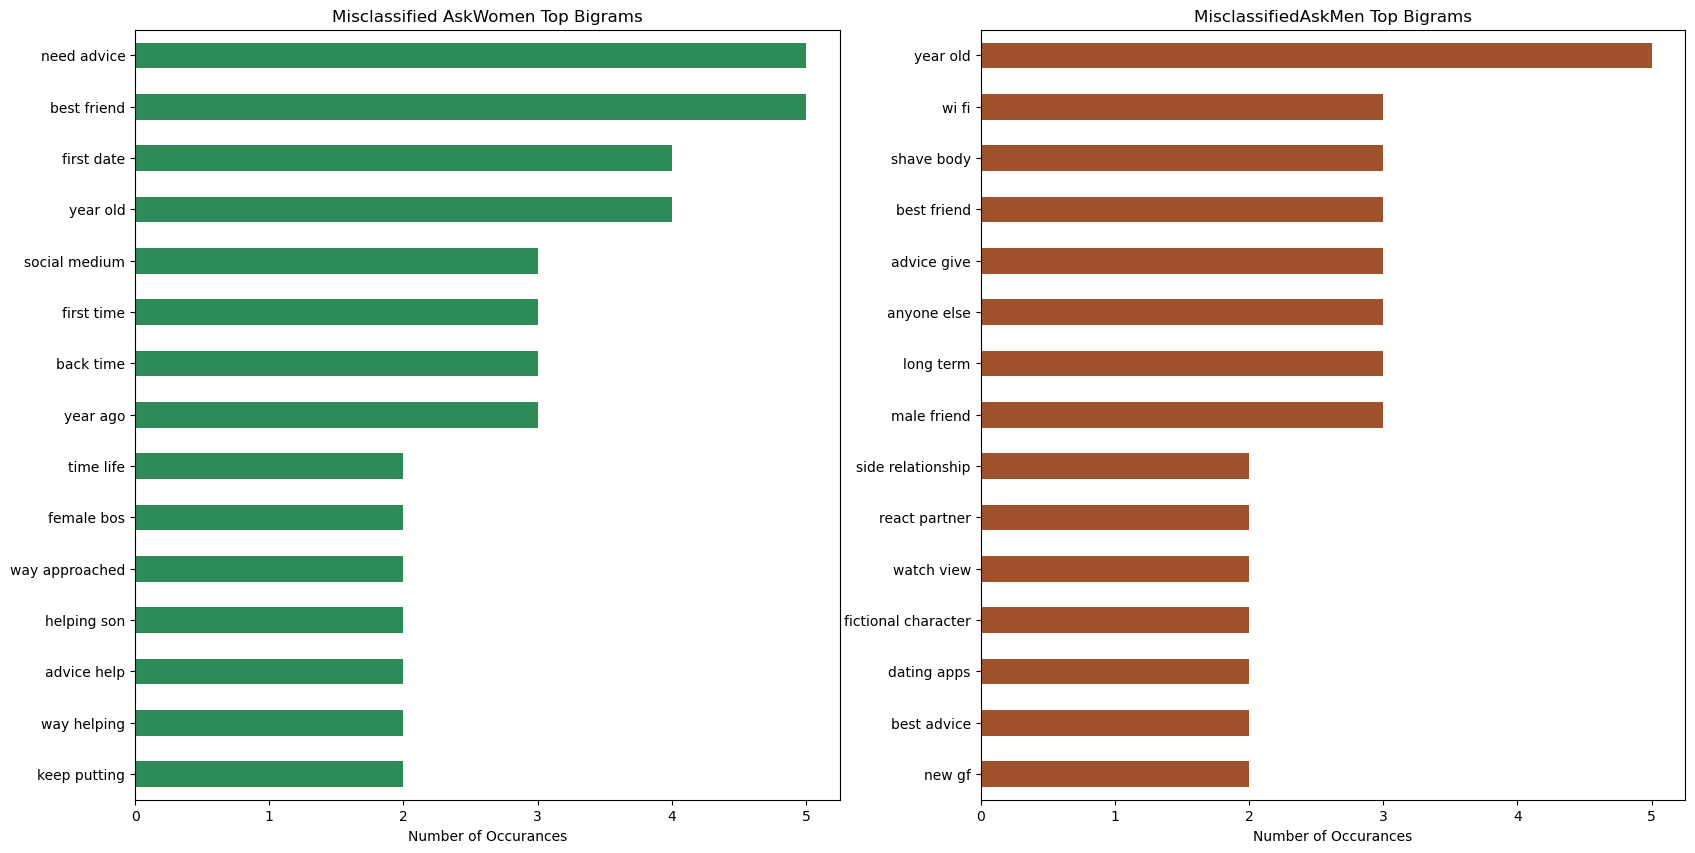

In [109]:
fig, ax = plt.subplots(1, 2, figsize= (20,10))

women_bi_df.sum().sort_values(ascending= False).head(15).plot(kind= "barh", ax=ax[0], color= "seagreen")
men_bi_df.sum().sort_values(ascending= False).head(15).plot(kind= "barh", ax=ax[1], color= "sienna")

ax[0].set(xlabel='Number of Occurances', title= "Misclassified AskWomen Top Bigrams")
ax[1].set(xlabel='Number of Occurances', title= "MisclassifiedAskMen Top Bigrams")

ax[0].invert_yaxis()
ax[1].invert_yaxis();


When looking at the top bigrams from each type of misclassified posts, there is also some overlap. Some of the overlaps here are: "best friend" and bigrams centered around "advice".

In [114]:
cv_tri= CountVectorizer(stop_words= lem_stop, tokenizer= my_lemmatizer, preprocessor= my_preprocessor, token_pattern= None, ngram_range=(3,3))

women_tri= cv_tri.fit_transform(misclass_women["title"])
women_tri_df= pd.DataFrame(women_tri.todense(), columns= cv_tri.get_feature_names_out())

men_tri= cv_tri.fit_transform(misclass_men["title"])
men_tri_df= pd.DataFrame(men_tri.todense(), columns= cv_tri.get_feature_names_out())

In [128]:
women_tri_df.sum().sort_values(ascending= False).head(20)

hand asked dance      2
dose casual dating    2
keep putting hand     2
job 2 month           2
middle 20's female    2
middle aged keep      2
new job 2             2
asked dance work      2
dance work new        2
way helping son       2
helping son middle    2
work new job          2
aged keep putting     2
first time life       2
20's female bos       2
try come back         2
casual dating mean    2
bos middle aged       2
son middle 20's       2
female bos middle     2
dtype: int64

In [125]:
men_tri_df.sum().sort_values(ascending= False).head(15)

physical side relationship        2
year old self                     2
react partner spat                2
partner spat face                 2
'overweight' range perspective    1
post getting removed              1
pregnant even actually            1
pregnant child could              1
preferred method dealing          1
prefer wear skirt                 1
prefer tomboy girly               1
prefer submissive dominant        1
potential partner moved           1
post wrong first                  1
positive attention experience     1
dtype: int64

Once we move to tri-grams, we can see there are very few occurances of each. However, for AskWomen there are a decent number of trigrams reguarding a "son", "work" and "job". While for AskMen there are only 4 trigrams with multiple occurances, two of which involve "spat".